In [1]:
import os, sys
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from skimage.transform import resize
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import os
os.getcwd()

'/workspace/case_study_7'

### mnist data

In [3]:
mnist_data = input_data.read_data_sets("./MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### mnist_clutter data

In [4]:
mnist = np.load('./mnist_sequence1_sample_5distortions5x5.npz')

# 3. 1번 모델을 mnist clutter 데이터에 맞게 마지막 fc layer만 training 하기

In [5]:
tr_x = mnist_data.train.images
tr_y = mnist_data.train.labels
val_x = mnist_data.validation.images
val_y = mnist_data.validation.labels
ts_x = mnist_data.test.images
ts_y = mnist_data.test.labels

In [6]:
class CNN:
    def __init__(self, activation_fn = tf.nn.relu,
                 initializer = tf.contrib.slim.xavier_initializer_conv2d(),
                 l2_scale = .001):
        
        with tf.variable_scope('input_layer'):
##            self._x = tf.placeholder(dtype = tf.float32, shape = [None, 1600])
            self._x = tf.placeholder(dtype = tf.float32, shape = [None, 784])
##            self._ximg = tf.reshape(tensor = self._x, shape = [-1, 40, 40, 1])
            self._ximg = tf.reshape(tensor = self._x, shape = [-1, 28, 28, 1])
            self._y = tf.placeholder(dtype = tf.float32, shape = [None, 10])
            self._training = tf.placeholder(dtype = tf.bool)
            self._keep_prob = tf.placeholder(dtype = tf.float32)
            
        with tf.contrib.slim.arg_scope([tf.contrib.slim.conv2d], kernel_size = [3,3], padding = 'SAME',
                                       weights_initializer = initializer,
                                       weights_regularizer = tf.contrib.slim.l2_regularizer(scale = l2_scale),
                                       stride = 1):
        
            with tf.variable_scope('conv_layer1'):
                _conv = tf.contrib.slim.conv2d(inputs = self._ximg, num_outputs = 32)
##                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = self._training)
                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = False)
                _relu = tf.nn.relu(features = _conv)
            
            with tf.variable_scope('conv_layer2'):
                _conv = tf.contrib.slim.conv2d(inputs = _conv, num_outputs = 32)
##                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = self._training)
                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = False)
                _relu = tf.nn.relu(features = _conv)
            
            with tf.variable_scope('max_pool1'):
                _pool = tf.contrib.slim.max_pool2d(inputs = _relu, kernel_size = [2,2], stride = 2)
            
            with tf.variable_scope('conv_layer3'):
                _conv = tf.contrib.slim.conv2d(inputs = _pool, num_outputs = 32)
##                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = self._training)
                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = False)
                _relu = tf.nn.relu(features = _conv)
            
            with tf.variable_scope('conv_layer4'):
                _conv = tf.contrib.slim.conv2d(inputs = _relu, num_outputs = 32)
##                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = self._training)
                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = False)
                _relu = tf.nn.relu(features = _conv)
                
            with tf.variable_scope('max_pool2'):
                _pool = tf.contrib.slim.max_pool2d(inputs = _relu, kernel_size = [2,2], stride = 2)

            with tf.variable_scope('conv_layer5'):
                _conv = tf.contrib.slim.conv2d(inputs = _pool, num_outputs = 32)
##                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = self._training)
                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = False)
                _relu = tf.nn.relu(features = _conv)
            
            with tf.variable_scope('conv_layer6'):
                _conv = tf.contrib.slim.conv2d(inputs = _relu, num_outputs = 32)
##                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = self._training)
                _conv = tf.layers.batch_normalization(inputs = _conv, momentum = .9, training = False)
                self._relu = tf.nn.relu(features = _conv)
            
            with tf.variable_scope('global_pool'):
##                _pooled = tf.contrib.slim.avg_pool2d(inputs = self._relu, kernel_size = [10,10], stride = 10)
                _pooled = tf.contrib.slim.avg_pool2d(inputs = self._relu, kernel_size = [7,7], stride = 10)
                _pooled = tf.contrib.slim.flatten(inputs = _pooled)
                _pooled = tf.contrib.slim.dropout(inputs = _pooled, keep_prob = self._keep_prob)
                
        with tf.variable_scope('output_layer'):
            self._score = tf.contrib.slim.fully_connected(inputs = _pooled, num_outputs = 10, activation_fn = None,
                                                          weights_initializer = tf.contrib.slim.xavier_initializer(uniform = False),
                                                          weights_regularizer = tf.contrib.slim.l2_regularizer(scale=l2_scale))
        with tf.variable_scope('loss'):
            _ce_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self._y, logits = self._score))
            _reg_term = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
            self._total_loss = _ce_loss + _reg_term
                
        self._update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        
        with tf.variable_scope('predict'):
            self._prediction = tf.nn.softmax(logits = self._score)
        
    def predict(self, sess, x_data, training = False, keep_prob = 1.):
        feed_predict = {self._x : x_data, self._training : training, self._keep_prob : keep_prob}
        return sess.run(self._prediction, feed_dict = feed_predict)
    
    def extract_featuremap(self, sess, x_data, training = False, keep_prob = 1.):
        feed_featuremap = {self._x : x_data, self._training : training, self._keep_prob : keep_prob}
        return sess.run(self._relu, feed_dict = feed_featuremap)

In [7]:
class Solver:
    def __init__(self, model, optimizer = tf.train.AdamOptimizer, var_list = None):
        self._model = model
        self._lr = tf.placeholder(dtype = tf.float32)
        self._optimizer = optimizer(learning_rate = self._lr)
        
        # Solver class는 model class로부터 생성된 instance를 input으로 받음. model class에서 저장한 객체변수를 아래와 같이 활용
        with tf.control_dependencies(self._model._update_ops):
            self._training_op = self._optimizer.minimize(loss = self._model._total_loss, var_list = var_list)
    
    def train(self, sess, x_data, y_data, lr, training = True, keep_prob = .5):
        feed_train = {self._model._x : x_data, self._model._y : y_data, self._lr : lr,
                      self._model._training : training, self._model._keep_prob : keep_prob}
        return sess.run(fetches = [self._training_op, self._model._total_loss], feed_dict = feed_train)
            
    def evaluate(self, sess, x_data, y_data, training = False, keep_prob = 1.):
        feed_loss = {self._model._x : x_data, self._model._y : y_data, self._model._training : training,
                     self._model._keep_prob : keep_prob}
        return sess.run(fetches = self._model._total_loss, feed_dict = feed_loss)

In [8]:
sess = tf.Session()
clutter_classifier = CNN()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [9]:
adam_solver = Solver(model = clutter_classifier)

In [10]:
# Hyper-parameters
batch_size = 50
n_epochs = 10
tr_loss_history = []
val_loss_history = []

In [11]:
sess.run(tf.global_variables_initializer())

In [12]:
for epoch in range(n_epochs):
    avg_tr_loss = 0
    avg_val_loss = 0
    total_batch = int(tr_x.shape[0] / batch_size)
    
    for step in range(total_batch):
        tr_indices = np.random.choice(np.arange(tr_x.shape[0]), size = batch_size, replace=False)
        val_indices = np.random.choice(np.arange(val_x.shape[0]), size = batch_size, replace=False)
        batch_xs = tr_x[tr_indices]
        batch_ys = tr_y[tr_indices]
        val_xs = val_x[val_indices]
        val_ys = val_y[val_indices]
        _, tr_loss = adam_solver.train(sess = sess, x_data = batch_xs, y_data = batch_ys, lr = 1e-3)
        val_loss = adam_solver.evaluate(sess = sess, x_data = val_xs, y_data = val_ys)

        avg_tr_loss += tr_loss / total_batch
        avg_val_loss += val_loss / total_batch
        if step % 50 == 0:
            print('step : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(step, tr_loss, val_loss))

    print('epoch : {:3}, tr_loss : {:.3f}, val_loss : {:.3f}'.format(epoch, avg_tr_loss, avg_val_loss))
    tr_loss_history.append(avg_tr_loss)
    val_loss_history.append(avg_val_loss)

step :   0, tr_loss : 2.393, val_loss : 2.390
step :  50, tr_loss : 2.297, val_loss : 2.070
step : 100, tr_loss : 1.848, val_loss : 1.742
step : 150, tr_loss : 1.811, val_loss : 1.177
step : 200, tr_loss : 1.186, val_loss : 0.739
step : 250, tr_loss : 0.855, val_loss : 0.577
step : 300, tr_loss : 0.860, val_loss : 0.487
step : 350, tr_loss : 0.642, val_loss : 0.483
step : 400, tr_loss : 0.595, val_loss : 0.275
step : 450, tr_loss : 0.650, val_loss : 0.205
step : 500, tr_loss : 0.511, val_loss : 0.366
step : 550, tr_loss : 0.555, val_loss : 0.284
step : 600, tr_loss : 0.634, val_loss : 0.322
step : 650, tr_loss : 0.556, val_loss : 0.242
step : 700, tr_loss : 0.536, val_loss : 0.289
step : 750, tr_loss : 0.425, val_loss : 0.174
step : 800, tr_loss : 0.433, val_loss : 0.344
step : 850, tr_loss : 0.615, val_loss : 0.177
step : 900, tr_loss : 0.470, val_loss : 0.194
step : 950, tr_loss : 0.391, val_loss : 0.345
step : 1000, tr_loss : 0.281, val_loss : 0.207
step : 1050, tr_loss : 0.586, val

step : 850, tr_loss : 0.313, val_loss : 0.110
step : 900, tr_loss : 0.214, val_loss : 0.139
step : 950, tr_loss : 0.256, val_loss : 0.247
step : 1000, tr_loss : 0.150, val_loss : 0.125
step : 1050, tr_loss : 0.389, val_loss : 0.145
epoch :   7, tr_loss : 0.214, val_loss : 0.146
step :   0, tr_loss : 0.212, val_loss : 0.129
step :  50, tr_loss : 0.292, val_loss : 0.177
step : 100, tr_loss : 0.244, val_loss : 0.192
step : 150, tr_loss : 0.379, val_loss : 0.140
step : 200, tr_loss : 0.258, val_loss : 0.225
step : 250, tr_loss : 0.126, val_loss : 0.095
step : 300, tr_loss : 0.112, val_loss : 0.111
step : 350, tr_loss : 0.136, val_loss : 0.103
step : 400, tr_loss : 0.214, val_loss : 0.168
step : 450, tr_loss : 0.150, val_loss : 0.103
step : 500, tr_loss : 0.220, val_loss : 0.144
step : 550, tr_loss : 0.282, val_loss : 0.149
step : 600, tr_loss : 0.229, val_loss : 0.142
step : 650, tr_loss : 0.150, val_loss : 0.129
step : 700, tr_loss : 0.105, val_loss : 0.095
step : 750, tr_loss : 0.294, va

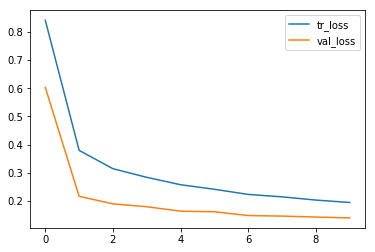

In [13]:
plt.plot(tr_loss_history, label = 'tr_loss')
plt.plot(val_loss_history, label = 'val_loss')
plt.legend()

In [14]:
tr_x = mnist['X_train']
tr_y = mnist['y_train']
val_x = mnist['X_valid']
val_y = mnist['y_valid']
ts_x = mnist['X_test']
ts_y = mnist['y_test']

### mnist_clutter_test_x_reshape (40x40 -> 28x28)

In [15]:
print(ts_x.shape)
print(ts_y.shape)

(1000, 1600)
(1000, 1)


In [16]:
delete_list = [0,1,2, 7, 12, 17, 22, 27, 32, 37,38,39]

tmp_list = np.ndarray(shape=(1, 784))
print(tmp_list[0].shape)

(784,)


In [17]:
for i in range(1000):
    reshape_mat=ts_x[i].reshape((40,40))
    reshape_mat1=np.delete(reshape_mat, delete_list, 0)
    reshape_mat2=np.delete(reshape_mat1, delete_list, 1)
    reshape_mat3=reshape_mat2.reshape(1,784)
    print(tmp_list.shape, reshape_mat3.shape)
    tmp_list = np.vstack((tmp_list, reshape_mat3))

(1, 784) (1, 784)
(2, 784) (1, 784)
(3, 784) (1, 784)
(4, 784) (1, 784)
(5, 784) (1, 784)
(6, 784) (1, 784)
(7, 784) (1, 784)
(8, 784) (1, 784)
(9, 784) (1, 784)
(10, 784) (1, 784)
(11, 784) (1, 784)
(12, 784) (1, 784)
(13, 784) (1, 784)
(14, 784) (1, 784)
(15, 784) (1, 784)
(16, 784) (1, 784)
(17, 784) (1, 784)
(18, 784) (1, 784)
(19, 784) (1, 784)
(20, 784) (1, 784)
(21, 784) (1, 784)
(22, 784) (1, 784)
(23, 784) (1, 784)
(24, 784) (1, 784)
(25, 784) (1, 784)
(26, 784) (1, 784)
(27, 784) (1, 784)
(28, 784) (1, 784)
(29, 784) (1, 784)
(30, 784) (1, 784)
(31, 784) (1, 784)
(32, 784) (1, 784)
(33, 784) (1, 784)
(34, 784) (1, 784)
(35, 784) (1, 784)
(36, 784) (1, 784)
(37, 784) (1, 784)
(38, 784) (1, 784)
(39, 784) (1, 784)
(40, 784) (1, 784)
(41, 784) (1, 784)
(42, 784) (1, 784)
(43, 784) (1, 784)
(44, 784) (1, 784)
(45, 784) (1, 784)
(46, 784) (1, 784)
(47, 784) (1, 784)
(48, 784) (1, 784)
(49, 784) (1, 784)
(50, 784) (1, 784)
(51, 784) (1, 784)
(52, 784) (1, 784)
(53, 784) (1, 784)
(5

(831, 784) (1, 784)
(832, 784) (1, 784)
(833, 784) (1, 784)
(834, 784) (1, 784)
(835, 784) (1, 784)
(836, 784) (1, 784)
(837, 784) (1, 784)
(838, 784) (1, 784)
(839, 784) (1, 784)
(840, 784) (1, 784)
(841, 784) (1, 784)
(842, 784) (1, 784)
(843, 784) (1, 784)
(844, 784) (1, 784)
(845, 784) (1, 784)
(846, 784) (1, 784)
(847, 784) (1, 784)
(848, 784) (1, 784)
(849, 784) (1, 784)
(850, 784) (1, 784)
(851, 784) (1, 784)
(852, 784) (1, 784)
(853, 784) (1, 784)
(854, 784) (1, 784)
(855, 784) (1, 784)
(856, 784) (1, 784)
(857, 784) (1, 784)
(858, 784) (1, 784)
(859, 784) (1, 784)
(860, 784) (1, 784)
(861, 784) (1, 784)
(862, 784) (1, 784)
(863, 784) (1, 784)
(864, 784) (1, 784)
(865, 784) (1, 784)
(866, 784) (1, 784)
(867, 784) (1, 784)
(868, 784) (1, 784)
(869, 784) (1, 784)
(870, 784) (1, 784)
(871, 784) (1, 784)
(872, 784) (1, 784)
(873, 784) (1, 784)
(874, 784) (1, 784)
(875, 784) (1, 784)
(876, 784) (1, 784)
(877, 784) (1, 784)
(878, 784) (1, 784)
(879, 784) (1, 784)
(880, 784) (1, 784)


In [18]:
print(tmp_list.shape)
print(tmp_list[1:].shape)

(1001, 784)
(1000, 784)


In [19]:
ts_x = tmp_list[1:]

print(type(ts_x))
print(ts_x.shape)

<class 'numpy.ndarray'>
(1000, 784)


### mnist_clutter_train_x_reshape (40x40 -> 28x28)

In [20]:
print(tr_x.shape)
print(tr_y.shape)

(10000, 1600)
(10000, 1)


In [21]:
delete_list = [0,1,2, 7, 12, 17, 22, 27, 32, 37,38,39]

tmp_list = np.ndarray(shape=(1, 784))
print(tmp_list[0].shape)

(784,)


In [22]:
for i in range(len(tr_x)):
    reshape_mat=tr_x[i].reshape((40,40))
    reshape_mat1=np.delete(reshape_mat, delete_list, 0)
    reshape_mat2=np.delete(reshape_mat1, delete_list, 1)
    reshape_mat3=reshape_mat2.reshape(1,784)
    print(tmp_list.shape, reshape_mat3.shape)
    tmp_list = np.vstack((tmp_list, reshape_mat3))

(1, 784) (1, 784)
(2, 784) (1, 784)
(3, 784) (1, 784)
(4, 784) (1, 784)
(5, 784) (1, 784)
(6, 784) (1, 784)
(7, 784) (1, 784)
(8, 784) (1, 784)
(9, 784) (1, 784)
(10, 784) (1, 784)
(11, 784) (1, 784)
(12, 784) (1, 784)
(13, 784) (1, 784)
(14, 784) (1, 784)
(15, 784) (1, 784)
(16, 784) (1, 784)
(17, 784) (1, 784)
(18, 784) (1, 784)
(19, 784) (1, 784)
(20, 784) (1, 784)
(21, 784) (1, 784)
(22, 784) (1, 784)
(23, 784) (1, 784)
(24, 784) (1, 784)
(25, 784) (1, 784)
(26, 784) (1, 784)
(27, 784) (1, 784)
(28, 784) (1, 784)
(29, 784) (1, 784)
(30, 784) (1, 784)
(31, 784) (1, 784)
(32, 784) (1, 784)
(33, 784) (1, 784)
(34, 784) (1, 784)
(35, 784) (1, 784)
(36, 784) (1, 784)
(37, 784) (1, 784)
(38, 784) (1, 784)
(39, 784) (1, 784)
(40, 784) (1, 784)
(41, 784) (1, 784)
(42, 784) (1, 784)
(43, 784) (1, 784)
(44, 784) (1, 784)
(45, 784) (1, 784)
(46, 784) (1, 784)
(47, 784) (1, 784)
(48, 784) (1, 784)
(49, 784) (1, 784)
(50, 784) (1, 784)
(51, 784) (1, 784)
(52, 784) (1, 784)
(53, 784) (1, 784)
(5

(446, 784) (1, 784)
(447, 784) (1, 784)
(448, 784) (1, 784)
(449, 784) (1, 784)
(450, 784) (1, 784)
(451, 784) (1, 784)
(452, 784) (1, 784)
(453, 784) (1, 784)
(454, 784) (1, 784)
(455, 784) (1, 784)
(456, 784) (1, 784)
(457, 784) (1, 784)
(458, 784) (1, 784)
(459, 784) (1, 784)
(460, 784) (1, 784)
(461, 784) (1, 784)
(462, 784) (1, 784)
(463, 784) (1, 784)
(464, 784) (1, 784)
(465, 784) (1, 784)
(466, 784) (1, 784)
(467, 784) (1, 784)
(468, 784) (1, 784)
(469, 784) (1, 784)
(470, 784) (1, 784)
(471, 784) (1, 784)
(472, 784) (1, 784)
(473, 784) (1, 784)
(474, 784) (1, 784)
(475, 784) (1, 784)
(476, 784) (1, 784)
(477, 784) (1, 784)
(478, 784) (1, 784)
(479, 784) (1, 784)
(480, 784) (1, 784)
(481, 784) (1, 784)
(482, 784) (1, 784)
(483, 784) (1, 784)
(484, 784) (1, 784)
(485, 784) (1, 784)
(486, 784) (1, 784)
(487, 784) (1, 784)
(488, 784) (1, 784)
(489, 784) (1, 784)
(490, 784) (1, 784)
(491, 784) (1, 784)
(492, 784) (1, 784)
(493, 784) (1, 784)
(494, 784) (1, 784)
(495, 784) (1, 784)


(945, 784) (1, 784)
(946, 784) (1, 784)
(947, 784) (1, 784)
(948, 784) (1, 784)
(949, 784) (1, 784)
(950, 784) (1, 784)
(951, 784) (1, 784)
(952, 784) (1, 784)
(953, 784) (1, 784)
(954, 784) (1, 784)
(955, 784) (1, 784)
(956, 784) (1, 784)
(957, 784) (1, 784)
(958, 784) (1, 784)
(959, 784) (1, 784)
(960, 784) (1, 784)
(961, 784) (1, 784)
(962, 784) (1, 784)
(963, 784) (1, 784)
(964, 784) (1, 784)
(965, 784) (1, 784)
(966, 784) (1, 784)
(967, 784) (1, 784)
(968, 784) (1, 784)
(969, 784) (1, 784)
(970, 784) (1, 784)
(971, 784) (1, 784)
(972, 784) (1, 784)
(973, 784) (1, 784)
(974, 784) (1, 784)
(975, 784) (1, 784)
(976, 784) (1, 784)
(977, 784) (1, 784)
(978, 784) (1, 784)
(979, 784) (1, 784)
(980, 784) (1, 784)
(981, 784) (1, 784)
(982, 784) (1, 784)
(983, 784) (1, 784)
(984, 784) (1, 784)
(985, 784) (1, 784)
(986, 784) (1, 784)
(987, 784) (1, 784)
(988, 784) (1, 784)
(989, 784) (1, 784)
(990, 784) (1, 784)
(991, 784) (1, 784)
(992, 784) (1, 784)
(993, 784) (1, 784)
(994, 784) (1, 784)


(1415, 784) (1, 784)
(1416, 784) (1, 784)
(1417, 784) (1, 784)
(1418, 784) (1, 784)
(1419, 784) (1, 784)
(1420, 784) (1, 784)
(1421, 784) (1, 784)
(1422, 784) (1, 784)
(1423, 784) (1, 784)
(1424, 784) (1, 784)
(1425, 784) (1, 784)
(1426, 784) (1, 784)
(1427, 784) (1, 784)
(1428, 784) (1, 784)
(1429, 784) (1, 784)
(1430, 784) (1, 784)
(1431, 784) (1, 784)
(1432, 784) (1, 784)
(1433, 784) (1, 784)
(1434, 784) (1, 784)
(1435, 784) (1, 784)
(1436, 784) (1, 784)
(1437, 784) (1, 784)
(1438, 784) (1, 784)
(1439, 784) (1, 784)
(1440, 784) (1, 784)
(1441, 784) (1, 784)
(1442, 784) (1, 784)
(1443, 784) (1, 784)
(1444, 784) (1, 784)
(1445, 784) (1, 784)
(1446, 784) (1, 784)
(1447, 784) (1, 784)
(1448, 784) (1, 784)
(1449, 784) (1, 784)
(1450, 784) (1, 784)
(1451, 784) (1, 784)
(1452, 784) (1, 784)
(1453, 784) (1, 784)
(1454, 784) (1, 784)
(1455, 784) (1, 784)
(1456, 784) (1, 784)
(1457, 784) (1, 784)
(1458, 784) (1, 784)
(1459, 784) (1, 784)
(1460, 784) (1, 784)
(1461, 784) (1, 784)
(1462, 784) (

(1880, 784) (1, 784)
(1881, 784) (1, 784)
(1882, 784) (1, 784)
(1883, 784) (1, 784)
(1884, 784) (1, 784)
(1885, 784) (1, 784)
(1886, 784) (1, 784)
(1887, 784) (1, 784)
(1888, 784) (1, 784)
(1889, 784) (1, 784)
(1890, 784) (1, 784)
(1891, 784) (1, 784)
(1892, 784) (1, 784)
(1893, 784) (1, 784)
(1894, 784) (1, 784)
(1895, 784) (1, 784)
(1896, 784) (1, 784)
(1897, 784) (1, 784)
(1898, 784) (1, 784)
(1899, 784) (1, 784)
(1900, 784) (1, 784)
(1901, 784) (1, 784)
(1902, 784) (1, 784)
(1903, 784) (1, 784)
(1904, 784) (1, 784)
(1905, 784) (1, 784)
(1906, 784) (1, 784)
(1907, 784) (1, 784)
(1908, 784) (1, 784)
(1909, 784) (1, 784)
(1910, 784) (1, 784)
(1911, 784) (1, 784)
(1912, 784) (1, 784)
(1913, 784) (1, 784)
(1914, 784) (1, 784)
(1915, 784) (1, 784)
(1916, 784) (1, 784)
(1917, 784) (1, 784)
(1918, 784) (1, 784)
(1919, 784) (1, 784)
(1920, 784) (1, 784)
(1921, 784) (1, 784)
(1922, 784) (1, 784)
(1923, 784) (1, 784)
(1924, 784) (1, 784)
(1925, 784) (1, 784)
(1926, 784) (1, 784)
(1927, 784) (

(2271, 784) (1, 784)
(2272, 784) (1, 784)
(2273, 784) (1, 784)
(2274, 784) (1, 784)
(2275, 784) (1, 784)
(2276, 784) (1, 784)
(2277, 784) (1, 784)
(2278, 784) (1, 784)
(2279, 784) (1, 784)
(2280, 784) (1, 784)
(2281, 784) (1, 784)
(2282, 784) (1, 784)
(2283, 784) (1, 784)
(2284, 784) (1, 784)
(2285, 784) (1, 784)
(2286, 784) (1, 784)
(2287, 784) (1, 784)
(2288, 784) (1, 784)
(2289, 784) (1, 784)
(2290, 784) (1, 784)
(2291, 784) (1, 784)
(2292, 784) (1, 784)
(2293, 784) (1, 784)
(2294, 784) (1, 784)
(2295, 784) (1, 784)
(2296, 784) (1, 784)
(2297, 784) (1, 784)
(2298, 784) (1, 784)
(2299, 784) (1, 784)
(2300, 784) (1, 784)
(2301, 784) (1, 784)
(2302, 784) (1, 784)
(2303, 784) (1, 784)
(2304, 784) (1, 784)
(2305, 784) (1, 784)
(2306, 784) (1, 784)
(2307, 784) (1, 784)
(2308, 784) (1, 784)
(2309, 784) (1, 784)
(2310, 784) (1, 784)
(2311, 784) (1, 784)
(2312, 784) (1, 784)
(2313, 784) (1, 784)
(2314, 784) (1, 784)
(2315, 784) (1, 784)
(2316, 784) (1, 784)
(2317, 784) (1, 784)
(2318, 784) (

(2666, 784) (1, 784)
(2667, 784) (1, 784)
(2668, 784) (1, 784)
(2669, 784) (1, 784)
(2670, 784) (1, 784)
(2671, 784) (1, 784)
(2672, 784) (1, 784)
(2673, 784) (1, 784)
(2674, 784) (1, 784)
(2675, 784) (1, 784)
(2676, 784) (1, 784)
(2677, 784) (1, 784)
(2678, 784) (1, 784)
(2679, 784) (1, 784)
(2680, 784) (1, 784)
(2681, 784) (1, 784)
(2682, 784) (1, 784)
(2683, 784) (1, 784)
(2684, 784) (1, 784)
(2685, 784) (1, 784)
(2686, 784) (1, 784)
(2687, 784) (1, 784)
(2688, 784) (1, 784)
(2689, 784) (1, 784)
(2690, 784) (1, 784)
(2691, 784) (1, 784)
(2692, 784) (1, 784)
(2693, 784) (1, 784)
(2694, 784) (1, 784)
(2695, 784) (1, 784)
(2696, 784) (1, 784)
(2697, 784) (1, 784)
(2698, 784) (1, 784)
(2699, 784) (1, 784)
(2700, 784) (1, 784)
(2701, 784) (1, 784)
(2702, 784) (1, 784)
(2703, 784) (1, 784)
(2704, 784) (1, 784)
(2705, 784) (1, 784)
(2706, 784) (1, 784)
(2707, 784) (1, 784)
(2708, 784) (1, 784)
(2709, 784) (1, 784)
(2710, 784) (1, 784)
(2711, 784) (1, 784)
(2712, 784) (1, 784)
(2713, 784) (

(3078, 784) (1, 784)
(3079, 784) (1, 784)
(3080, 784) (1, 784)
(3081, 784) (1, 784)
(3082, 784) (1, 784)
(3083, 784) (1, 784)
(3084, 784) (1, 784)
(3085, 784) (1, 784)
(3086, 784) (1, 784)
(3087, 784) (1, 784)
(3088, 784) (1, 784)
(3089, 784) (1, 784)
(3090, 784) (1, 784)
(3091, 784) (1, 784)
(3092, 784) (1, 784)
(3093, 784) (1, 784)
(3094, 784) (1, 784)
(3095, 784) (1, 784)
(3096, 784) (1, 784)
(3097, 784) (1, 784)
(3098, 784) (1, 784)
(3099, 784) (1, 784)
(3100, 784) (1, 784)
(3101, 784) (1, 784)
(3102, 784) (1, 784)
(3103, 784) (1, 784)
(3104, 784) (1, 784)
(3105, 784) (1, 784)
(3106, 784) (1, 784)
(3107, 784) (1, 784)
(3108, 784) (1, 784)
(3109, 784) (1, 784)
(3110, 784) (1, 784)
(3111, 784) (1, 784)
(3112, 784) (1, 784)
(3113, 784) (1, 784)
(3114, 784) (1, 784)
(3115, 784) (1, 784)
(3116, 784) (1, 784)
(3117, 784) (1, 784)
(3118, 784) (1, 784)
(3119, 784) (1, 784)
(3120, 784) (1, 784)
(3121, 784) (1, 784)
(3122, 784) (1, 784)
(3123, 784) (1, 784)
(3124, 784) (1, 784)
(3125, 784) (

(3507, 784) (1, 784)
(3508, 784) (1, 784)
(3509, 784) (1, 784)
(3510, 784) (1, 784)
(3511, 784) (1, 784)
(3512, 784) (1, 784)
(3513, 784) (1, 784)
(3514, 784) (1, 784)
(3515, 784) (1, 784)
(3516, 784) (1, 784)
(3517, 784) (1, 784)
(3518, 784) (1, 784)
(3519, 784) (1, 784)
(3520, 784) (1, 784)
(3521, 784) (1, 784)
(3522, 784) (1, 784)
(3523, 784) (1, 784)
(3524, 784) (1, 784)
(3525, 784) (1, 784)
(3526, 784) (1, 784)
(3527, 784) (1, 784)
(3528, 784) (1, 784)
(3529, 784) (1, 784)
(3530, 784) (1, 784)
(3531, 784) (1, 784)
(3532, 784) (1, 784)
(3533, 784) (1, 784)
(3534, 784) (1, 784)
(3535, 784) (1, 784)
(3536, 784) (1, 784)
(3537, 784) (1, 784)
(3538, 784) (1, 784)
(3539, 784) (1, 784)
(3540, 784) (1, 784)
(3541, 784) (1, 784)
(3542, 784) (1, 784)
(3543, 784) (1, 784)
(3544, 784) (1, 784)
(3545, 784) (1, 784)
(3546, 784) (1, 784)
(3547, 784) (1, 784)
(3548, 784) (1, 784)
(3549, 784) (1, 784)
(3550, 784) (1, 784)
(3551, 784) (1, 784)
(3552, 784) (1, 784)
(3553, 784) (1, 784)
(3554, 784) (

(3935, 784) (1, 784)
(3936, 784) (1, 784)
(3937, 784) (1, 784)
(3938, 784) (1, 784)
(3939, 784) (1, 784)
(3940, 784) (1, 784)
(3941, 784) (1, 784)
(3942, 784) (1, 784)
(3943, 784) (1, 784)
(3944, 784) (1, 784)
(3945, 784) (1, 784)
(3946, 784) (1, 784)
(3947, 784) (1, 784)
(3948, 784) (1, 784)
(3949, 784) (1, 784)
(3950, 784) (1, 784)
(3951, 784) (1, 784)
(3952, 784) (1, 784)
(3953, 784) (1, 784)
(3954, 784) (1, 784)
(3955, 784) (1, 784)
(3956, 784) (1, 784)
(3957, 784) (1, 784)
(3958, 784) (1, 784)
(3959, 784) (1, 784)
(3960, 784) (1, 784)
(3961, 784) (1, 784)
(3962, 784) (1, 784)
(3963, 784) (1, 784)
(3964, 784) (1, 784)
(3965, 784) (1, 784)
(3966, 784) (1, 784)
(3967, 784) (1, 784)
(3968, 784) (1, 784)
(3969, 784) (1, 784)
(3970, 784) (1, 784)
(3971, 784) (1, 784)
(3972, 784) (1, 784)
(3973, 784) (1, 784)
(3974, 784) (1, 784)
(3975, 784) (1, 784)
(3976, 784) (1, 784)
(3977, 784) (1, 784)
(3978, 784) (1, 784)
(3979, 784) (1, 784)
(3980, 784) (1, 784)
(3981, 784) (1, 784)
(3982, 784) (

(4330, 784) (1, 784)
(4331, 784) (1, 784)
(4332, 784) (1, 784)
(4333, 784) (1, 784)
(4334, 784) (1, 784)
(4335, 784) (1, 784)
(4336, 784) (1, 784)
(4337, 784) (1, 784)
(4338, 784) (1, 784)
(4339, 784) (1, 784)
(4340, 784) (1, 784)
(4341, 784) (1, 784)
(4342, 784) (1, 784)
(4343, 784) (1, 784)
(4344, 784) (1, 784)
(4345, 784) (1, 784)
(4346, 784) (1, 784)
(4347, 784) (1, 784)
(4348, 784) (1, 784)
(4349, 784) (1, 784)
(4350, 784) (1, 784)
(4351, 784) (1, 784)
(4352, 784) (1, 784)
(4353, 784) (1, 784)
(4354, 784) (1, 784)
(4355, 784) (1, 784)
(4356, 784) (1, 784)
(4357, 784) (1, 784)
(4358, 784) (1, 784)
(4359, 784) (1, 784)
(4360, 784) (1, 784)
(4361, 784) (1, 784)
(4362, 784) (1, 784)
(4363, 784) (1, 784)
(4364, 784) (1, 784)
(4365, 784) (1, 784)
(4366, 784) (1, 784)
(4367, 784) (1, 784)
(4368, 784) (1, 784)
(4369, 784) (1, 784)
(4370, 784) (1, 784)
(4371, 784) (1, 784)
(4372, 784) (1, 784)
(4373, 784) (1, 784)
(4374, 784) (1, 784)
(4375, 784) (1, 784)
(4376, 784) (1, 784)
(4377, 784) (

(4735, 784) (1, 784)
(4736, 784) (1, 784)
(4737, 784) (1, 784)
(4738, 784) (1, 784)
(4739, 784) (1, 784)
(4740, 784) (1, 784)
(4741, 784) (1, 784)
(4742, 784) (1, 784)
(4743, 784) (1, 784)
(4744, 784) (1, 784)
(4745, 784) (1, 784)
(4746, 784) (1, 784)
(4747, 784) (1, 784)
(4748, 784) (1, 784)
(4749, 784) (1, 784)
(4750, 784) (1, 784)
(4751, 784) (1, 784)
(4752, 784) (1, 784)
(4753, 784) (1, 784)
(4754, 784) (1, 784)
(4755, 784) (1, 784)
(4756, 784) (1, 784)
(4757, 784) (1, 784)
(4758, 784) (1, 784)
(4759, 784) (1, 784)
(4760, 784) (1, 784)
(4761, 784) (1, 784)
(4762, 784) (1, 784)
(4763, 784) (1, 784)
(4764, 784) (1, 784)
(4765, 784) (1, 784)
(4766, 784) (1, 784)
(4767, 784) (1, 784)
(4768, 784) (1, 784)
(4769, 784) (1, 784)
(4770, 784) (1, 784)
(4771, 784) (1, 784)
(4772, 784) (1, 784)
(4773, 784) (1, 784)
(4774, 784) (1, 784)
(4775, 784) (1, 784)
(4776, 784) (1, 784)
(4777, 784) (1, 784)
(4778, 784) (1, 784)
(4779, 784) (1, 784)
(4780, 784) (1, 784)
(4781, 784) (1, 784)
(4782, 784) (

(5129, 784) (1, 784)
(5130, 784) (1, 784)
(5131, 784) (1, 784)
(5132, 784) (1, 784)
(5133, 784) (1, 784)
(5134, 784) (1, 784)
(5135, 784) (1, 784)
(5136, 784) (1, 784)
(5137, 784) (1, 784)
(5138, 784) (1, 784)
(5139, 784) (1, 784)
(5140, 784) (1, 784)
(5141, 784) (1, 784)
(5142, 784) (1, 784)
(5143, 784) (1, 784)
(5144, 784) (1, 784)
(5145, 784) (1, 784)
(5146, 784) (1, 784)
(5147, 784) (1, 784)
(5148, 784) (1, 784)
(5149, 784) (1, 784)
(5150, 784) (1, 784)
(5151, 784) (1, 784)
(5152, 784) (1, 784)
(5153, 784) (1, 784)
(5154, 784) (1, 784)
(5155, 784) (1, 784)
(5156, 784) (1, 784)
(5157, 784) (1, 784)
(5158, 784) (1, 784)
(5159, 784) (1, 784)
(5160, 784) (1, 784)
(5161, 784) (1, 784)
(5162, 784) (1, 784)
(5163, 784) (1, 784)
(5164, 784) (1, 784)
(5165, 784) (1, 784)
(5166, 784) (1, 784)
(5167, 784) (1, 784)
(5168, 784) (1, 784)
(5169, 784) (1, 784)
(5170, 784) (1, 784)
(5171, 784) (1, 784)
(5172, 784) (1, 784)
(5173, 784) (1, 784)
(5174, 784) (1, 784)
(5175, 784) (1, 784)
(5176, 784) (

(5523, 784) (1, 784)
(5524, 784) (1, 784)
(5525, 784) (1, 784)
(5526, 784) (1, 784)
(5527, 784) (1, 784)
(5528, 784) (1, 784)
(5529, 784) (1, 784)
(5530, 784) (1, 784)
(5531, 784) (1, 784)
(5532, 784) (1, 784)
(5533, 784) (1, 784)
(5534, 784) (1, 784)
(5535, 784) (1, 784)
(5536, 784) (1, 784)
(5537, 784) (1, 784)
(5538, 784) (1, 784)
(5539, 784) (1, 784)
(5540, 784) (1, 784)
(5541, 784) (1, 784)
(5542, 784) (1, 784)
(5543, 784) (1, 784)
(5544, 784) (1, 784)
(5545, 784) (1, 784)
(5546, 784) (1, 784)
(5547, 784) (1, 784)
(5548, 784) (1, 784)
(5549, 784) (1, 784)
(5550, 784) (1, 784)
(5551, 784) (1, 784)
(5552, 784) (1, 784)
(5553, 784) (1, 784)
(5554, 784) (1, 784)
(5555, 784) (1, 784)
(5556, 784) (1, 784)
(5557, 784) (1, 784)
(5558, 784) (1, 784)
(5559, 784) (1, 784)
(5560, 784) (1, 784)
(5561, 784) (1, 784)
(5562, 784) (1, 784)
(5563, 784) (1, 784)
(5564, 784) (1, 784)
(5565, 784) (1, 784)
(5566, 784) (1, 784)
(5567, 784) (1, 784)
(5568, 784) (1, 784)
(5569, 784) (1, 784)
(5570, 784) (

(5915, 784) (1, 784)
(5916, 784) (1, 784)
(5917, 784) (1, 784)
(5918, 784) (1, 784)
(5919, 784) (1, 784)
(5920, 784) (1, 784)
(5921, 784) (1, 784)
(5922, 784) (1, 784)
(5923, 784) (1, 784)
(5924, 784) (1, 784)
(5925, 784) (1, 784)
(5926, 784) (1, 784)
(5927, 784) (1, 784)
(5928, 784) (1, 784)
(5929, 784) (1, 784)
(5930, 784) (1, 784)
(5931, 784) (1, 784)
(5932, 784) (1, 784)
(5933, 784) (1, 784)
(5934, 784) (1, 784)
(5935, 784) (1, 784)
(5936, 784) (1, 784)
(5937, 784) (1, 784)
(5938, 784) (1, 784)
(5939, 784) (1, 784)
(5940, 784) (1, 784)
(5941, 784) (1, 784)
(5942, 784) (1, 784)
(5943, 784) (1, 784)
(5944, 784) (1, 784)
(5945, 784) (1, 784)
(5946, 784) (1, 784)
(5947, 784) (1, 784)
(5948, 784) (1, 784)
(5949, 784) (1, 784)
(5950, 784) (1, 784)
(5951, 784) (1, 784)
(5952, 784) (1, 784)
(5953, 784) (1, 784)
(5954, 784) (1, 784)
(5955, 784) (1, 784)
(5956, 784) (1, 784)
(5957, 784) (1, 784)
(5958, 784) (1, 784)
(5959, 784) (1, 784)
(5960, 784) (1, 784)
(5961, 784) (1, 784)
(5962, 784) (

(6309, 784) (1, 784)
(6310, 784) (1, 784)
(6311, 784) (1, 784)
(6312, 784) (1, 784)
(6313, 784) (1, 784)
(6314, 784) (1, 784)
(6315, 784) (1, 784)
(6316, 784) (1, 784)
(6317, 784) (1, 784)
(6318, 784) (1, 784)
(6319, 784) (1, 784)
(6320, 784) (1, 784)
(6321, 784) (1, 784)
(6322, 784) (1, 784)
(6323, 784) (1, 784)
(6324, 784) (1, 784)
(6325, 784) (1, 784)
(6326, 784) (1, 784)
(6327, 784) (1, 784)
(6328, 784) (1, 784)
(6329, 784) (1, 784)
(6330, 784) (1, 784)
(6331, 784) (1, 784)
(6332, 784) (1, 784)
(6333, 784) (1, 784)
(6334, 784) (1, 784)
(6335, 784) (1, 784)
(6336, 784) (1, 784)
(6337, 784) (1, 784)
(6338, 784) (1, 784)
(6339, 784) (1, 784)
(6340, 784) (1, 784)
(6341, 784) (1, 784)
(6342, 784) (1, 784)
(6343, 784) (1, 784)
(6344, 784) (1, 784)
(6345, 784) (1, 784)
(6346, 784) (1, 784)
(6347, 784) (1, 784)
(6348, 784) (1, 784)
(6349, 784) (1, 784)
(6350, 784) (1, 784)
(6351, 784) (1, 784)
(6352, 784) (1, 784)
(6353, 784) (1, 784)
(6354, 784) (1, 784)
(6355, 784) (1, 784)
(6356, 784) (

(6700, 784) (1, 784)
(6701, 784) (1, 784)
(6702, 784) (1, 784)
(6703, 784) (1, 784)
(6704, 784) (1, 784)
(6705, 784) (1, 784)
(6706, 784) (1, 784)
(6707, 784) (1, 784)
(6708, 784) (1, 784)
(6709, 784) (1, 784)
(6710, 784) (1, 784)
(6711, 784) (1, 784)
(6712, 784) (1, 784)
(6713, 784) (1, 784)
(6714, 784) (1, 784)
(6715, 784) (1, 784)
(6716, 784) (1, 784)
(6717, 784) (1, 784)
(6718, 784) (1, 784)
(6719, 784) (1, 784)
(6720, 784) (1, 784)
(6721, 784) (1, 784)
(6722, 784) (1, 784)
(6723, 784) (1, 784)
(6724, 784) (1, 784)
(6725, 784) (1, 784)
(6726, 784) (1, 784)
(6727, 784) (1, 784)
(6728, 784) (1, 784)
(6729, 784) (1, 784)
(6730, 784) (1, 784)
(6731, 784) (1, 784)
(6732, 784) (1, 784)
(6733, 784) (1, 784)
(6734, 784) (1, 784)
(6735, 784) (1, 784)
(6736, 784) (1, 784)
(6737, 784) (1, 784)
(6738, 784) (1, 784)
(6739, 784) (1, 784)
(6740, 784) (1, 784)
(6741, 784) (1, 784)
(6742, 784) (1, 784)
(6743, 784) (1, 784)
(6744, 784) (1, 784)
(6745, 784) (1, 784)
(6746, 784) (1, 784)
(6747, 784) (

(7091, 784) (1, 784)
(7092, 784) (1, 784)
(7093, 784) (1, 784)
(7094, 784) (1, 784)
(7095, 784) (1, 784)
(7096, 784) (1, 784)
(7097, 784) (1, 784)
(7098, 784) (1, 784)
(7099, 784) (1, 784)
(7100, 784) (1, 784)
(7101, 784) (1, 784)
(7102, 784) (1, 784)
(7103, 784) (1, 784)
(7104, 784) (1, 784)
(7105, 784) (1, 784)
(7106, 784) (1, 784)
(7107, 784) (1, 784)
(7108, 784) (1, 784)
(7109, 784) (1, 784)
(7110, 784) (1, 784)
(7111, 784) (1, 784)
(7112, 784) (1, 784)
(7113, 784) (1, 784)
(7114, 784) (1, 784)
(7115, 784) (1, 784)
(7116, 784) (1, 784)
(7117, 784) (1, 784)
(7118, 784) (1, 784)
(7119, 784) (1, 784)
(7120, 784) (1, 784)
(7121, 784) (1, 784)
(7122, 784) (1, 784)
(7123, 784) (1, 784)
(7124, 784) (1, 784)
(7125, 784) (1, 784)
(7126, 784) (1, 784)
(7127, 784) (1, 784)
(7128, 784) (1, 784)
(7129, 784) (1, 784)
(7130, 784) (1, 784)
(7131, 784) (1, 784)
(7132, 784) (1, 784)
(7133, 784) (1, 784)
(7134, 784) (1, 784)
(7135, 784) (1, 784)
(7136, 784) (1, 784)
(7137, 784) (1, 784)
(7138, 784) (

(7483, 784) (1, 784)
(7484, 784) (1, 784)
(7485, 784) (1, 784)
(7486, 784) (1, 784)
(7487, 784) (1, 784)
(7488, 784) (1, 784)
(7489, 784) (1, 784)
(7490, 784) (1, 784)
(7491, 784) (1, 784)
(7492, 784) (1, 784)
(7493, 784) (1, 784)
(7494, 784) (1, 784)
(7495, 784) (1, 784)
(7496, 784) (1, 784)
(7497, 784) (1, 784)
(7498, 784) (1, 784)
(7499, 784) (1, 784)
(7500, 784) (1, 784)
(7501, 784) (1, 784)
(7502, 784) (1, 784)
(7503, 784) (1, 784)
(7504, 784) (1, 784)
(7505, 784) (1, 784)
(7506, 784) (1, 784)
(7507, 784) (1, 784)
(7508, 784) (1, 784)
(7509, 784) (1, 784)
(7510, 784) (1, 784)
(7511, 784) (1, 784)
(7512, 784) (1, 784)
(7513, 784) (1, 784)
(7514, 784) (1, 784)
(7515, 784) (1, 784)
(7516, 784) (1, 784)
(7517, 784) (1, 784)
(7518, 784) (1, 784)
(7519, 784) (1, 784)
(7520, 784) (1, 784)
(7521, 784) (1, 784)
(7522, 784) (1, 784)
(7523, 784) (1, 784)
(7524, 784) (1, 784)
(7525, 784) (1, 784)
(7526, 784) (1, 784)
(7527, 784) (1, 784)
(7528, 784) (1, 784)
(7529, 784) (1, 784)
(7530, 784) (

(7878, 784) (1, 784)
(7879, 784) (1, 784)
(7880, 784) (1, 784)
(7881, 784) (1, 784)
(7882, 784) (1, 784)
(7883, 784) (1, 784)
(7884, 784) (1, 784)
(7885, 784) (1, 784)
(7886, 784) (1, 784)
(7887, 784) (1, 784)
(7888, 784) (1, 784)
(7889, 784) (1, 784)
(7890, 784) (1, 784)
(7891, 784) (1, 784)
(7892, 784) (1, 784)
(7893, 784) (1, 784)
(7894, 784) (1, 784)
(7895, 784) (1, 784)
(7896, 784) (1, 784)
(7897, 784) (1, 784)
(7898, 784) (1, 784)
(7899, 784) (1, 784)
(7900, 784) (1, 784)
(7901, 784) (1, 784)
(7902, 784) (1, 784)
(7903, 784) (1, 784)
(7904, 784) (1, 784)
(7905, 784) (1, 784)
(7906, 784) (1, 784)
(7907, 784) (1, 784)
(7908, 784) (1, 784)
(7909, 784) (1, 784)
(7910, 784) (1, 784)
(7911, 784) (1, 784)
(7912, 784) (1, 784)
(7913, 784) (1, 784)
(7914, 784) (1, 784)
(7915, 784) (1, 784)
(7916, 784) (1, 784)
(7917, 784) (1, 784)
(7918, 784) (1, 784)
(7919, 784) (1, 784)
(7920, 784) (1, 784)
(7921, 784) (1, 784)
(7922, 784) (1, 784)
(7923, 784) (1, 784)
(7924, 784) (1, 784)
(7925, 784) (

(8274, 784) (1, 784)
(8275, 784) (1, 784)
(8276, 784) (1, 784)
(8277, 784) (1, 784)
(8278, 784) (1, 784)
(8279, 784) (1, 784)
(8280, 784) (1, 784)
(8281, 784) (1, 784)
(8282, 784) (1, 784)
(8283, 784) (1, 784)
(8284, 784) (1, 784)
(8285, 784) (1, 784)
(8286, 784) (1, 784)
(8287, 784) (1, 784)
(8288, 784) (1, 784)
(8289, 784) (1, 784)
(8290, 784) (1, 784)
(8291, 784) (1, 784)
(8292, 784) (1, 784)
(8293, 784) (1, 784)
(8294, 784) (1, 784)
(8295, 784) (1, 784)
(8296, 784) (1, 784)
(8297, 784) (1, 784)
(8298, 784) (1, 784)
(8299, 784) (1, 784)
(8300, 784) (1, 784)
(8301, 784) (1, 784)
(8302, 784) (1, 784)
(8303, 784) (1, 784)
(8304, 784) (1, 784)
(8305, 784) (1, 784)
(8306, 784) (1, 784)
(8307, 784) (1, 784)
(8308, 784) (1, 784)
(8309, 784) (1, 784)
(8310, 784) (1, 784)
(8311, 784) (1, 784)
(8312, 784) (1, 784)
(8313, 784) (1, 784)
(8314, 784) (1, 784)
(8315, 784) (1, 784)
(8316, 784) (1, 784)
(8317, 784) (1, 784)
(8318, 784) (1, 784)
(8319, 784) (1, 784)
(8320, 784) (1, 784)
(8321, 784) (

(8665, 784) (1, 784)
(8666, 784) (1, 784)
(8667, 784) (1, 784)
(8668, 784) (1, 784)
(8669, 784) (1, 784)
(8670, 784) (1, 784)
(8671, 784) (1, 784)
(8672, 784) (1, 784)
(8673, 784) (1, 784)
(8674, 784) (1, 784)
(8675, 784) (1, 784)
(8676, 784) (1, 784)
(8677, 784) (1, 784)
(8678, 784) (1, 784)
(8679, 784) (1, 784)
(8680, 784) (1, 784)
(8681, 784) (1, 784)
(8682, 784) (1, 784)
(8683, 784) (1, 784)
(8684, 784) (1, 784)
(8685, 784) (1, 784)
(8686, 784) (1, 784)
(8687, 784) (1, 784)
(8688, 784) (1, 784)
(8689, 784) (1, 784)
(8690, 784) (1, 784)
(8691, 784) (1, 784)
(8692, 784) (1, 784)
(8693, 784) (1, 784)
(8694, 784) (1, 784)
(8695, 784) (1, 784)
(8696, 784) (1, 784)
(8697, 784) (1, 784)
(8698, 784) (1, 784)
(8699, 784) (1, 784)
(8700, 784) (1, 784)
(8701, 784) (1, 784)
(8702, 784) (1, 784)
(8703, 784) (1, 784)
(8704, 784) (1, 784)
(8705, 784) (1, 784)
(8706, 784) (1, 784)
(8707, 784) (1, 784)
(8708, 784) (1, 784)
(8709, 784) (1, 784)
(8710, 784) (1, 784)
(8711, 784) (1, 784)
(8712, 784) (

(9059, 784) (1, 784)
(9060, 784) (1, 784)
(9061, 784) (1, 784)
(9062, 784) (1, 784)
(9063, 784) (1, 784)
(9064, 784) (1, 784)
(9065, 784) (1, 784)
(9066, 784) (1, 784)
(9067, 784) (1, 784)
(9068, 784) (1, 784)
(9069, 784) (1, 784)
(9070, 784) (1, 784)
(9071, 784) (1, 784)
(9072, 784) (1, 784)
(9073, 784) (1, 784)
(9074, 784) (1, 784)
(9075, 784) (1, 784)
(9076, 784) (1, 784)
(9077, 784) (1, 784)
(9078, 784) (1, 784)
(9079, 784) (1, 784)
(9080, 784) (1, 784)
(9081, 784) (1, 784)
(9082, 784) (1, 784)
(9083, 784) (1, 784)
(9084, 784) (1, 784)
(9085, 784) (1, 784)
(9086, 784) (1, 784)
(9087, 784) (1, 784)
(9088, 784) (1, 784)
(9089, 784) (1, 784)
(9090, 784) (1, 784)
(9091, 784) (1, 784)
(9092, 784) (1, 784)
(9093, 784) (1, 784)
(9094, 784) (1, 784)
(9095, 784) (1, 784)
(9096, 784) (1, 784)
(9097, 784) (1, 784)
(9098, 784) (1, 784)
(9099, 784) (1, 784)
(9100, 784) (1, 784)
(9101, 784) (1, 784)
(9102, 784) (1, 784)
(9103, 784) (1, 784)
(9104, 784) (1, 784)
(9105, 784) (1, 784)
(9106, 784) (

(9455, 784) (1, 784)
(9456, 784) (1, 784)
(9457, 784) (1, 784)
(9458, 784) (1, 784)
(9459, 784) (1, 784)
(9460, 784) (1, 784)
(9461, 784) (1, 784)
(9462, 784) (1, 784)
(9463, 784) (1, 784)
(9464, 784) (1, 784)
(9465, 784) (1, 784)
(9466, 784) (1, 784)
(9467, 784) (1, 784)
(9468, 784) (1, 784)
(9469, 784) (1, 784)
(9470, 784) (1, 784)
(9471, 784) (1, 784)
(9472, 784) (1, 784)
(9473, 784) (1, 784)
(9474, 784) (1, 784)
(9475, 784) (1, 784)
(9476, 784) (1, 784)
(9477, 784) (1, 784)
(9478, 784) (1, 784)
(9479, 784) (1, 784)
(9480, 784) (1, 784)
(9481, 784) (1, 784)
(9482, 784) (1, 784)
(9483, 784) (1, 784)
(9484, 784) (1, 784)
(9485, 784) (1, 784)
(9486, 784) (1, 784)
(9487, 784) (1, 784)
(9488, 784) (1, 784)
(9489, 784) (1, 784)
(9490, 784) (1, 784)
(9491, 784) (1, 784)
(9492, 784) (1, 784)
(9493, 784) (1, 784)
(9494, 784) (1, 784)
(9495, 784) (1, 784)
(9496, 784) (1, 784)
(9497, 784) (1, 784)
(9498, 784) (1, 784)
(9499, 784) (1, 784)
(9500, 784) (1, 784)
(9501, 784) (1, 784)
(9502, 784) (

(9848, 784) (1, 784)
(9849, 784) (1, 784)
(9850, 784) (1, 784)
(9851, 784) (1, 784)
(9852, 784) (1, 784)
(9853, 784) (1, 784)
(9854, 784) (1, 784)
(9855, 784) (1, 784)
(9856, 784) (1, 784)
(9857, 784) (1, 784)
(9858, 784) (1, 784)
(9859, 784) (1, 784)
(9860, 784) (1, 784)
(9861, 784) (1, 784)
(9862, 784) (1, 784)
(9863, 784) (1, 784)
(9864, 784) (1, 784)
(9865, 784) (1, 784)
(9866, 784) (1, 784)
(9867, 784) (1, 784)
(9868, 784) (1, 784)
(9869, 784) (1, 784)
(9870, 784) (1, 784)
(9871, 784) (1, 784)
(9872, 784) (1, 784)
(9873, 784) (1, 784)
(9874, 784) (1, 784)
(9875, 784) (1, 784)
(9876, 784) (1, 784)
(9877, 784) (1, 784)
(9878, 784) (1, 784)
(9879, 784) (1, 784)
(9880, 784) (1, 784)
(9881, 784) (1, 784)
(9882, 784) (1, 784)
(9883, 784) (1, 784)
(9884, 784) (1, 784)
(9885, 784) (1, 784)
(9886, 784) (1, 784)
(9887, 784) (1, 784)
(9888, 784) (1, 784)
(9889, 784) (1, 784)
(9890, 784) (1, 784)
(9891, 784) (1, 784)
(9892, 784) (1, 784)
(9893, 784) (1, 784)
(9894, 784) (1, 784)
(9895, 784) (

In [23]:
print(tmp_list.shape)
print(tmp_list[1:].shape)

(10001, 784)
(10000, 784)


In [24]:
tr_x = tmp_list[1:]

print(type(tr_x))
print(tr_x.shape)

<class 'numpy.ndarray'>
(10000, 784)


### mnist_clutter_val_x_reshape (40x40 -> 28x28)

In [25]:
print(val_x.shape)
print(val_y.shape)

(1000, 1600)
(1000, 1)


In [26]:
delete_list = [0,1,2, 7, 12, 17, 22, 27, 32, 37,38,39]

tmp_list = np.ndarray(shape=(1, 784))
print(tmp_list[0].shape)

(784,)


In [27]:
for i in range(len(val_x)):
    reshape_mat=val_x[i].reshape((40,40))
    reshape_mat1=np.delete(reshape_mat, delete_list, 0)
    reshape_mat2=np.delete(reshape_mat1, delete_list, 1)
    reshape_mat3=reshape_mat2.reshape(1,784)
    print(tmp_list.shape, reshape_mat3.shape)
    tmp_list = np.vstack((tmp_list, reshape_mat3))

(1, 784) (1, 784)
(2, 784) (1, 784)
(3, 784) (1, 784)
(4, 784) (1, 784)
(5, 784) (1, 784)
(6, 784) (1, 784)
(7, 784) (1, 784)
(8, 784) (1, 784)
(9, 784) (1, 784)
(10, 784) (1, 784)
(11, 784) (1, 784)
(12, 784) (1, 784)
(13, 784) (1, 784)
(14, 784) (1, 784)
(15, 784) (1, 784)
(16, 784) (1, 784)
(17, 784) (1, 784)
(18, 784) (1, 784)
(19, 784) (1, 784)
(20, 784) (1, 784)
(21, 784) (1, 784)
(22, 784) (1, 784)
(23, 784) (1, 784)
(24, 784) (1, 784)
(25, 784) (1, 784)
(26, 784) (1, 784)
(27, 784) (1, 784)
(28, 784) (1, 784)
(29, 784) (1, 784)
(30, 784) (1, 784)
(31, 784) (1, 784)
(32, 784) (1, 784)
(33, 784) (1, 784)
(34, 784) (1, 784)
(35, 784) (1, 784)
(36, 784) (1, 784)
(37, 784) (1, 784)
(38, 784) (1, 784)
(39, 784) (1, 784)
(40, 784) (1, 784)
(41, 784) (1, 784)
(42, 784) (1, 784)
(43, 784) (1, 784)
(44, 784) (1, 784)
(45, 784) (1, 784)
(46, 784) (1, 784)
(47, 784) (1, 784)
(48, 784) (1, 784)
(49, 784) (1, 784)
(50, 784) (1, 784)
(51, 784) (1, 784)
(52, 784) (1, 784)
(53, 784) (1, 784)
(5

(798, 784) (1, 784)
(799, 784) (1, 784)
(800, 784) (1, 784)
(801, 784) (1, 784)
(802, 784) (1, 784)
(803, 784) (1, 784)
(804, 784) (1, 784)
(805, 784) (1, 784)
(806, 784) (1, 784)
(807, 784) (1, 784)
(808, 784) (1, 784)
(809, 784) (1, 784)
(810, 784) (1, 784)
(811, 784) (1, 784)
(812, 784) (1, 784)
(813, 784) (1, 784)
(814, 784) (1, 784)
(815, 784) (1, 784)
(816, 784) (1, 784)
(817, 784) (1, 784)
(818, 784) (1, 784)
(819, 784) (1, 784)
(820, 784) (1, 784)
(821, 784) (1, 784)
(822, 784) (1, 784)
(823, 784) (1, 784)
(824, 784) (1, 784)
(825, 784) (1, 784)
(826, 784) (1, 784)
(827, 784) (1, 784)
(828, 784) (1, 784)
(829, 784) (1, 784)
(830, 784) (1, 784)
(831, 784) (1, 784)
(832, 784) (1, 784)
(833, 784) (1, 784)
(834, 784) (1, 784)
(835, 784) (1, 784)
(836, 784) (1, 784)
(837, 784) (1, 784)
(838, 784) (1, 784)
(839, 784) (1, 784)
(840, 784) (1, 784)
(841, 784) (1, 784)
(842, 784) (1, 784)
(843, 784) (1, 784)
(844, 784) (1, 784)
(845, 784) (1, 784)
(846, 784) (1, 784)
(847, 784) (1, 784)


In [28]:
print(tmp_list.shape)
print(tmp_list[1:].shape)

(1001, 784)
(1000, 784)


In [29]:
val_x = tmp_list[1:]

print(type(val_x))
print(val_x.shape)

<class 'numpy.ndarray'>
(1000, 784)


### mnist_clutter_tr_y, val_y, ts_y one hot encoding

In [30]:
# One-hot representation function
def one_hot(label):
    enc = OneHotEncoder()
    enc.fit(label)
    res = enc.transform(label).toarray()
    return res

In [31]:
# transform
tr_y = one_hot(tr_y)
val_y = one_hot(val_y)
ts_y = one_hot(ts_y)

In [32]:
hat = clutter_classifier.predict(sess = sess, x_data = ts_x)

In [33]:
print('Accuracy : {:.2%}'.format(np.mean(np.argmax(hat, axis = 1) == np.argmax(ts_y, axis = 1))))

Accuracy : 85.20%


In [34]:
weights = sess.run(tf.get_collection(tf.GraphKeys.MODEL_VARIABLES, scope = 'output_layer')[0])
def cam(featuremap, weights, pred_class):
    pred_weights = weights[:,pred_class]
    output = np.zeros(featuremap.shape[1:3])
    
    for channel in range(weights.shape[0]):
        output += pred_weights[channel] * featuremap[0,:,:,channel] 
    output /= weights.shape[0]
##    output = resize(output, output_shape = [40,40], mode = 'reflect')
    output = resize(output, output_shape = [28,28], mode = 'reflect')
    output = (output - np.min(output)) / (np.max(output) - np.min(output))
    plt.imshow(output, cmap = 'jet', interpolation = 'bilinear')

Text(0.5,1,'2 is True label, 2 is prediction')

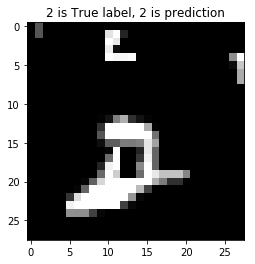

In [35]:
target_index = np.random.choice(np.arange(ts_y.shape[0]), size = 1)
hat = clutter_classifier.predict(sess = sess, x_data = ts_x[target_index])
##plt.imshow(ts_x[target_index].reshape(40,40), cmap = 'gray')
plt.imshow(ts_x[target_index].reshape(28,28), cmap = 'gray')
plt.title('{} is True label, {} is prediction'.format(np.argmax(ts_y[target_index]),np.argmax(hat)))

In [36]:
featuremap = clutter_classifier.extract_featuremap(sess = sess, x_data = ts_x[target_index])

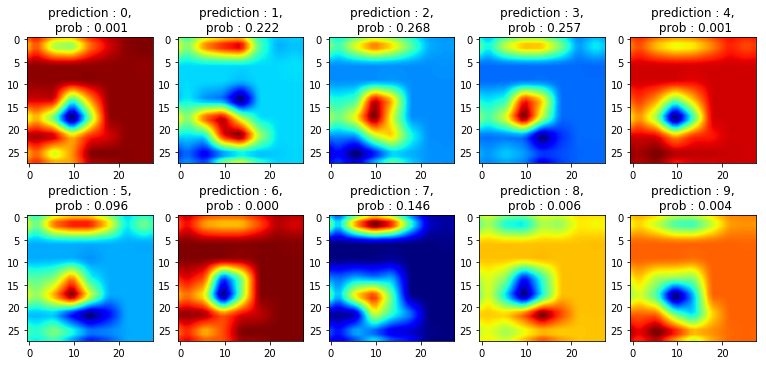

In [37]:
fig = plt.figure(figsize = (15, 6))
fig.subplots_adjust(right = .8)
for pred_class, pred_prob in enumerate(hat.flatten()):
    fig.add_subplot(2,5, pred_class + 1)
    cam(featuremap, weights, pred_class)
    plt.title('prediction : {},\n prob : {:.3f}'.format(pred_class, pred_prob))